1. Instalar las librerias necesarias

In [ ]:
pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 2.7 MB/s eta 0:00:00


2. Importar la librerias correspondientes para la ejecución del agente

In [ ]:
import os
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import random
from heapq import heappop, heappush
from pyproj import Transformer
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.optimize import linear_sum_assignment

3. Importación del mapa y puntos de interes (Para el ejemplo usaremos el distrito de Lince y sus iglesias afiliadas)

In [44]:
# Variables globales
velocidad_feligres = 10 # min/Km
tiempo_descanso_feligres_x_iglesia = 10 #min

# Definir el lugar y descargar el gráfico de red
place_name = "Lince, Lima, Peru"
tags = {'amenity': 'place_of_worship','religion': 'christian'}  # Tags para buscar iglesias

graph = ox.graph_from_place(place_name, network_type='drive')   # Grafo de una red
points = ox.features_from_place(place_name, tags)    # Puntos de interés


4. PRE-PROCESAMIENTO DE LOS DATOS

In [27]:
######################################################################################################
# PREPROCESAMIENTO DE LOS DATOS
######################################################################################################
points = points.dropna(subset=['amenity']) #se eliminan los registros que no tienen valor en la columna amenity
points = points.dropna(subset=['religion']) #se eliminan los registros que no tienen valor en la columna religion
points = points.dropna(subset=['name']) #se eliminan los registros que no tienen valor en la columna name

# Encontrar y eliminar nodos sin salida
dead_ends = [node for node, degree in graph.degree() if degree == 1]
graph.remove_nodes_from(dead_ends)

# Encontrar y eliminar nodos aislados
isolated_nodes = list(nx.isolates(graph))
graph.remove_nodes_from(isolated_nodes)

# Encontrar el GRAFO principal (excluye los componentes desconectados)
largest_component = max(nx.strongly_connected_components(graph), key=len)
graph = graph.subgraph(largest_component).copy()

# Encontrar y eliminar las rutas cerradas (se originan en una ubicación y terminan en la misma ubicación)
nodos_autoreferenciados = list(nx.selfloop_edges(graph))
graph.remove_nodes_from(nodos_autoreferenciados)

# Coordenadas de las iglesias
coords = []
for point in points.itertuples():
    if point.geometry.geom_type == 'Point':
        coords.append((point.geometry.y, point.geometry.x))
    elif point.geometry.geom_type in ['Polygon', 'MultiPolygon']:
        coords.append((point.geometry.centroid.y, point.geometry.centroid.x))

# Nodo más cercano a cada iglesia
nodes = [ox.distance.nearest_nodes(graph, point[1], point[0]) for point in coords]
nodes = [node for node in nodes if graph.degree[node] > 1]  # Excluir nodos con solo un camino

# Extraer un nodo como punto de partida
all_nodes = set(graph.nodes)    # Nodos del mapa
#print("all_nodos:",all_nodes)
iglesia_nodes = set(nodes)      # Nodos de iglesias
#print("iglesia_nodes:",iglesia_nodes)
no_iglesia_nodes = list(all_nodes - iglesia_nodes)  # Solo nodos donde no sea iglesia
#print("no_iglesia_nodes",no_iglesia_nodes)

random_node = 263112175 #random.choice(no_iglesia_nodes) #263112013
# Crear la matriz de distancias entre los nodos de interés usando el algoritmo A*
all_nodes = [random_node] + nodes
print("ID de Nodos de interes(Punto inicial + Iglesias):",all_nodes)

ID de Nodos de interes(Punto inicial + Iglesias): [263112175, 263122144, 263121077, 263358002, 263120509, 10313710286, 263122099, 263121082, 257946473, 1273591262, 263357752]


PRESENTAR ESTADISTICAS
Luego de finalizado el pre-procesamiento de los datos, se presentan las estadisticas.

n: 352
m: 653
k_avg: 3.710227272727273
edge_length_total: 57321.73799999998
edge_length_avg: 87.78214088820825
streets_per_node_avg: 3.6107954545454546
streets_per_node_counts: {0: 0, 1: 2, 2: 0, 3: 133, 4: 215, 5: 2}
streets_per_node_proportions: {0: 0.0, 1: 0.005681818181818182, 2: 0.0, 3: 0.3778409090909091, 4: 0.6107954545454546, 5: 0.005681818181818182}
intersection_count: 350
street_length_total: 52921.82700000002
street_segment_count: 599
street_length_avg: 88.35029549248752
circuity_avg: 1.0012227653273107
self_loop_proportion: 0.0


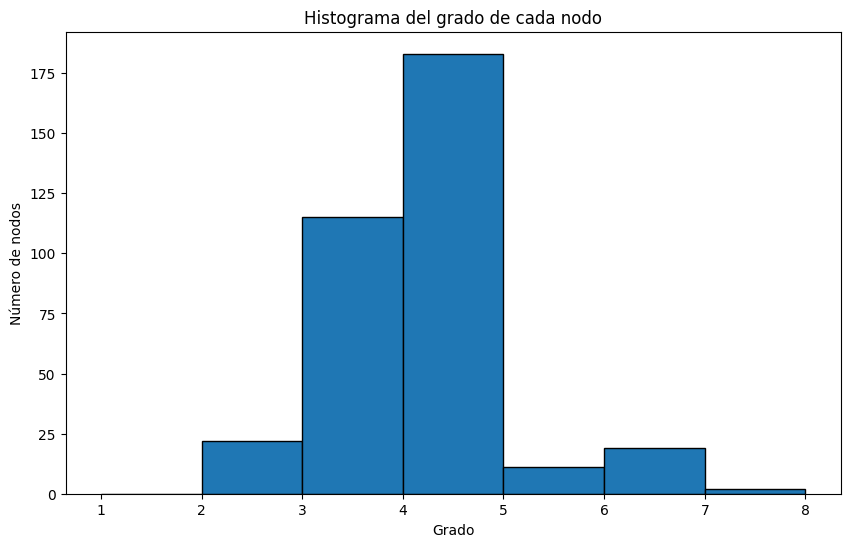

El diámetro del grafo es: 36
El radio del grafo es: 18


In [ ]:
stats=ox.stats.basic_stats(graph)
for key, value in stats.items():
    print(f"{key}: {value}")
# Calcular el grado de cada nodo en el grafo
degrees = [graph.degree[node] for node in graph.nodes]

# Mostrar el histograma del grado de cada nodo
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=range(1, max(degrees) + 1), edgecolor='black')
plt.title('Histograma del grado de cada nodo')
plt.xlabel('Grado')
plt.ylabel('Número de nodos')
plt.show()

# Convertir el grafo dirigido en uno no dirigido
G_undirected = graph.to_undirected()

# Calcular el diámetro del grafo
diameter = nx.diameter(G_undirected, e=None, usebounds=False)

# Calcular el radio del grafo
radius = nx.radius(G_undirected)

# Imprimir el diámetro y el radio del grafo
print(f"El diámetro del grafo es: {diameter}")
print(f"El radio del grafo es: {radius}")

5. Definición de Función auxiliar para calculo de la distancia euclidiana (Heuristica)

In [ ]:
# Definir el transformador para proyectar las coordenadas y poder calcular la distancia euclideana en un sistema métrico
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32718", always_xy=True)

# Función heurística basada en la distancia euclidiana en coordenadas proyectadas
def euclidean_distance(node1, node2):
    x1, y1 = graph.nodes[node1]['x'], graph.nodes[node1]['y']
    x2, y2 = graph.nodes[node2]['x'], graph.nodes[node2]['y']
    x1_proj, y1_proj = transformer.transform(x1, y1)
    x2_proj, y2_proj = transformer.transform(x2, y2)
    return ((x1_proj - x2_proj) ** 2 + (y1_proj - y2_proj) ** 2) ** 0.5

6. ALGORITMO DE BUSQUEDA EN ESPACIO DE ESTADO: (A* + BACKTRACKING)


---


Cálculo de la distancia mas corta entre los puntos de interes (Nodo inicial + Iglesias) usando A*:

*   Definición de función A_star y uso de la libreria `networkx.a_astar_path` para calcular la ditancia mas corta entre los nodos de interes
*   Creación de matriz con distancias mas cortas entre pares de nodos de interes `dist_matrix`



In [8]:
# Implementar el algoritmo A* para encontrar la ruta más corta entre dos nodos
def astar_path(G, source, target, heuristic=euclidean_distance, weight='length'):
    return nx.astar_path(G, source, target, heuristic=heuristic, weight=weight)

# Crear la matriz de distancias entre los nodos de interés usando el algoritmo A*
dist_matrix = np.zeros((len(all_nodes), len(all_nodes)))
#print(dist_matrix)
for i, node1 in enumerate(all_nodes):
    for j, node2 in enumerate(all_nodes):
        if i != j:
            dist_matrix[i, j] = nx.astar_path_length(graph, node1, node2, heuristic=euclidean_distance, weight='length')
        else:
            dist_matrix[i, j] = np.inf  # Reemplazar ceros de la diagonal con infinito
print("Matriz de distancias mas cortas entre los nodos de interes:")
print(np.array2string(dist_matrix))

Matriz de distancias mas cortas entre los nodos de interes:
[[     inf 1499.59  1936.933 2127.316 1665.057 3145.662 1806.128 1541.906
  2273.663 2543.479 2113.164]
 [1283.764      inf 2060.691 1619.133 1868.659 3516.777 1300.494 1272.053
  1769.494 2040.4   1604.981]
 [1899.605 1414.878      inf  871.214  274.345 1991.188  577.948  607.991
   363.87   633.686  749.811]
 [2151.242 1162.524  915.479      inf  741.388 2404.47   519.656  845.704
   552.907  522.419  265.4  ]
 [1625.26  1461.021  271.876  917.357      inf 1837.169  624.091  654.134
   635.746  905.562  795.954]
 [2880.506 2872.703 1458.448 2327.793 1732.793      inf 2036.396 2066.439
  1818.429 1668.234 2207.636]
 [1994.489 1292.441  760.197  748.777  584.188 2300.064      inf  690.155
   469.     739.906  627.374]
 [1305.538  808.709  887.93  1021.068  616.054 2438.397  699.88       inf
  1167.415 1437.231 1006.916]
 [2263.419 1286.814  787.989  509.364  638.159 2276.98   643.946  969.994
       inf  394.929  389.69 ]
 [27

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


6. ALGORITMO DE BUSQUEDA EN ESPACIO DE ESTADO: (A* + BACKTRACKING)


---


Cálculo de la distancia mas corta entre los puntos de interes (Nodo inicial + Iglesias) usando A*:

*   Calculadas los las distancias mas cortas entre los nodos de interes, procedemos a encontrar el recorrido mas corto, visitando cada punto de interes una sola vez y partiendo del punto `random_node`. Para ello usamos backtracking y expandimos todas las rutas posibles.
*   Calculo del tamaño del camino mas corto `best_length`
*   Calculo del la ruta mas corta `best_path`

In [28]:
# Implementación del algoritmo de búsqueda en el espacio de estados
def tsp_backtracking(curr_node, visited, curr_length, best_length, best_path):
    if len(visited) == len(nodes) + 1:  # Todos los nodos visitados (nodos + nodo inicial)
        if curr_length < best_length[0]:
            best_length[0] = curr_length
            best_path[:] = visited[:]
        return

    for next_node in range(len(all_nodes)):
        if next_node not in visited:
            next_length = curr_length + dist_matrix[curr_node][next_node]
            if next_length < best_length[0]:
                visited.append(next_node)
                tsp_backtracking(next_node, visited, next_length, best_length, best_path)
                visited.pop()

best_length = [float('inf')]
best_path = []
tsp_backtracking(0, [0], 0, best_length, best_path)

# Obtener la ruta óptima en términos de nodos y resultados
optimal_order = [all_nodes[i] for i in best_path]
print(f"Numero de iglesias a visitar: {len(optimal_order)-1}")
print(f"Longitud total del recorrido: {best_length[0]} metros")
print(f"Orden óptimo de nodos: {optimal_order}")
print(f"Velocidad de los feligres: {velocidad_feligres} min/Km")
print(f"Tiempo neto de recorrido: {best_length[0]/1000 * velocidad_feligres} minutos")
print(f"Tiempo neto de recorrido: {(best_length[0]/1000 * velocidad_feligres)/60} horas")
print(f"tiempo de descanso en cada iglesia: {tiempo_descanso_feligres_x_iglesia} minutos")
print(f"Numero de iglesias descanso: {len(optimal_order)-2}")
print(f"Tiempo total de recorrido con descanso: {best_length[0]/1000 * velocidad_feligres + (len(optimal_order)-2) * tiempo_descanso_feligres_x_iglesia} minutos")
print(f"Tiempo total de recorrido con descanso: {(best_length[0]/1000 * velocidad_feligres + (len(optimal_order)-2) * tiempo_descanso_feligres_x_iglesia)/60} horas")


Numero de iglesias a visitar: 10
Longitud total del recorrido: 7800.2519999999995 metros
Orden óptimo de nodos: [263112175, 263122144, 263121082, 263120509, 263121077, 257946473, 263358002, 263357752, 263122099, 1273591262, 10313710286]
Velocidad de los feligres: 10 min/Km
Tiempo neto de recorrido: 78.00251999999999 minutos
Tiempo neto de recorrido: 1.300042 horas
tiempo de descanso en cada iglesia: 10 minutos
Numero de iglesias descanso: 9
Tiempo total de recorrido con descanso: 168.00252 minutos
Tiempo total de recorrido con descanso: 2.800042 horas


7. VISUALIZACION DE LOS DATOS

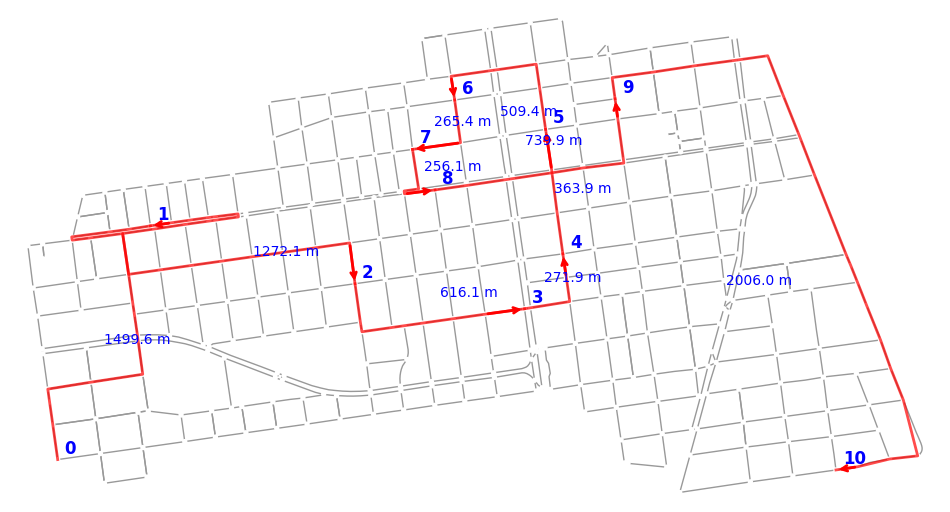

In [31]:
######################################################################################################
# Visualización de los datos
######################################################################################################
# Visualizar la ruta óptima en el grafo
fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(graph, ax=ax, show=False, close=False)

# Dibujar la ruta óptima
for i in range(len(optimal_order) - 1):
    path = nx.shortest_path(graph, optimal_order[i], optimal_order[i + 1], weight='length')
    path_coords = [(graph.nodes[node]['x'], graph.nodes[node]['y']) for node in path]
    x_coords, y_coords = zip(*path_coords)
    ax.plot(x_coords, y_coords, color='r', linewidth=2, alpha=0.7)
    ax.annotate('', xy=(x_coords[-1], y_coords[-1]), xytext=(x_coords[-2], y_coords[-2]),
                arrowprops=dict(arrowstyle='->', color='r', lw=2))

    # Calcular y mostrar la longitud del segmento
    segment_length = nx.astar_path_length(graph, optimal_order[i], optimal_order[i + 1], heuristic=euclidean_distance, weight='length')
    mid_x = (x_coords[0] + x_coords[-1]) / 2
    mid_y = (y_coords[0] + y_coords[-1]) / 2
    ax.text(mid_x, mid_y, f'{segment_length:.1f} m', fontsize=10, color='blue')

# Añadir etiquetas a los nodos en el orden de recorrido
for idx, node in enumerate(optimal_order):
    label = str(idx)
    ax.annotate(label, xy=(graph.nodes[node]['x'], graph.nodes[node]['y']), xytext=(5, 5),
                textcoords='offset points', color='blue', fontsize=12, fontweight='bold')

plt.show()

**8**. ALGORITMO DE BUSQUEDA EN ESPACIO DE ESTADO: (BFS)

In [32]:
def bfs_path(graph, start, goal):
    """

    Implementacion del algoritmo BFS.

    """

    queue = [(start, [start])]
    visited = set()
    while queue:
        (vertex, path) = queue.pop(0)
        if vertex in visited:
            continue
        for next_vertex in set(graph[vertex]) - visited:
            if next_vertex == goal:
                return path + [next_vertex]
            else:
                queue.append((next_vertex, path + [next_vertex]))
        visited.add(vertex)

    return []


In [33]:
def longitud_de_ruta(graph, path):
    """

    Calculo de la longitud de una ruta.

    """
    total_distance = 0
    for i in range(len(path) - 1):
        u = path[i]
        v = path[i + 1]
        # Sumar la longitud de la arista (u, v)
        edge_data = graph.get_edge_data(u, v)
        if edge_data:  # Verificar si existe la arista (u, v)
            total_distance += edge_data[0]['length']  # Sumamos la longitud de la arista
    return total_distance


In [34]:
ruta = 1
total_path_bfs = list()

posicion_inicial = 263112175
posicion_inicial_base = posicion_inicial
longitud_total = 0

# implementacion de BFS

for dest_node in iglesia_nodes:
    ruta_bfs = bfs_path(graph,posicion_inicial, dest_node)
    posicion_inicial = dest_node
    total_path_bfs.append(ruta_bfs)
    len_bfs =len (ruta_bfs) -1
    ruta_longitud = longitud_de_ruta(graph,ruta_bfs)
    print(f"Ruta {ruta}: numero de aristas: {len_bfs}")
    print(f"Longitud de ruta: {ruta_longitud} m")
    ruta += 1
    longitud_total += ruta_longitud

print(f"Longitud total de ruta: {longitud_total} m")


Ruta 1: numero de aristas: 19
Longitud de ruta: 1606.7450000000003 m
Ruta 2: numero de aristas: 24
Longitud de ruta: 2012.4910000000002 m
Ruta 3: numero de aristas: 23
Longitud de ruta: 2276.98 m
Ruta 4: numero de aristas: 25
Longitud de ruta: 2332.928 m
Ruta 5: numero de aristas: 6
Longitud de ruta: 521.547 m
Ruta 6: numero de aristas: 8
Longitud de ruta: 760.202 m
Ruta 7: numero de aristas: 8
Longitud de ruta: 753.077 m
Ruta 8: numero de aristas: 7
Longitud de ruta: 583.578 m
Ruta 9: numero de aristas: 8
Longitud de ruta: 616.0539999999999 m
Ruta 10: numero de aristas: 11
Longitud de ruta: 908.8599999999999 m
Longitud total de ruta: 12372.462 m


8.1. Visualizacion de los datos

[263112175, 263122144, 257946473, 10313710286, 263358002, 263122099, 263121077, 263357752, 263121082, 263120509, 1273591262]


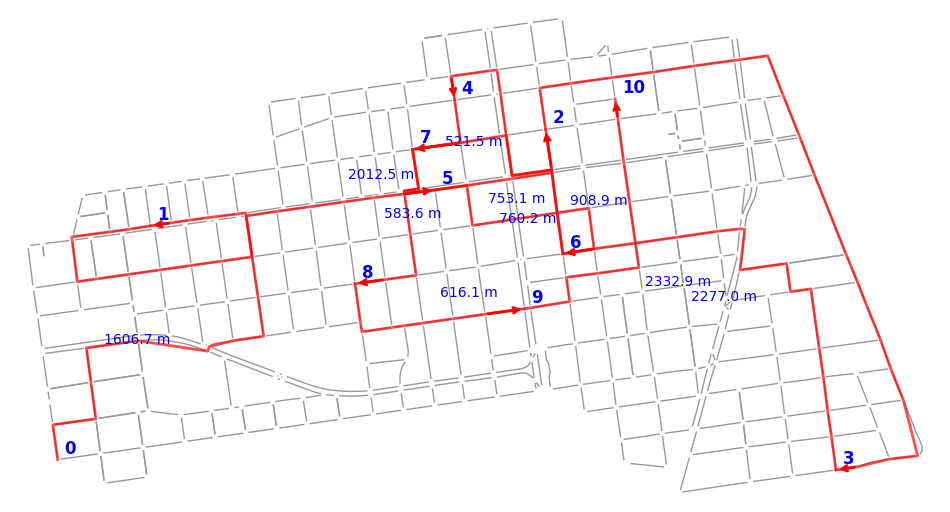

Numero de iglesias a visitar: 10
Longitud total del recorrido: 12372.462 metros
Orden óptimo de nodos: [263112175, 263122144, 263121082, 263120509, 263121077, 257946473, 263358002, 263357752, 263122099, 1273591262, 10313710286]
Velocidad de los feligres: 10 min/Km
Tiempo neto de recorrido: 123.72461999999999 minutos
Tiempo neto de recorrido: 2.062077 horas
tiempo de descanso en cada iglesia: 10 minutos
Numero de iglesias descanso: 9
Tiempo total de recorrido con descanso: 213.72462 minutos
Tiempo total de recorrido con descanso: 3.562077 horas


In [35]:
nodes_base = list(iglesia_nodes)
optimal_order = [posicion_inicial_base] + nodes_base
#optimal_order = optimal_order[0:1]
print(optimal_order)
fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(graph, ax=ax, show=False, close=False)



for i in range(len(optimal_order) - 1):
    path = total_path_bfs[i]
    path_coords = [(graph.nodes[node]['x'], graph.nodes[node]['y']) for node in path]
    x_coords, y_coords = zip(*path_coords)
    ax.plot(x_coords, y_coords, color='r', linewidth=2, alpha=0.7)
    ax.annotate('', xy=(x_coords[-1], y_coords[-1]), xytext=(x_coords[-2], y_coords[-2]),
                arrowprops=dict(arrowstyle='->', color='r', lw=2))

    # Calcular y mostrar la longitud del segmento
    segment_length = longitud_de_ruta(graph,path)
    mid_x = (x_coords[0] + x_coords[-1]) / 2
    mid_y = (y_coords[0] + y_coords[-1]) / 2
    ax.text(mid_x, mid_y, f'{segment_length:.1f} m', fontsize=10, color='blue')


# Añadir etiquetas a los nodos en el orden de recorrido
for idx, node in enumerate(optimal_order):
    label = str(idx)
    ax.annotate(label, xy=(graph.nodes[node]['x'], graph.nodes[node]['y']), xytext=(5, 5),
                textcoords='offset points', color='blue', fontsize=12, fontweight='bold')



plt.show()

# Obtener la ruta óptima en términos de nodos y resultados
optimal_order = [all_nodes[i] for i in best_path]
print(f"Numero de iglesias a visitar: {len(optimal_order)-1}")
print(f"Longitud total del recorrido: {longitud_total} metros")
print(f"Orden óptimo de nodos: {optimal_order}")
print(f"Velocidad de los feligres: {velocidad_feligres} min/Km")
print(f"Tiempo neto de recorrido: {longitud_total/1000 * velocidad_feligres} minutos")
print(f"Tiempo neto de recorrido: {(longitud_total/1000 * velocidad_feligres)/60} horas")
print(f"tiempo de descanso en cada iglesia: {tiempo_descanso_feligres_x_iglesia} minutos")
print(f"Numero de iglesias descanso: {len(optimal_order)-2}")
print(f"Tiempo total de recorrido con descanso: {longitud_total/1000 * velocidad_feligres + (len(optimal_order)-2) * tiempo_descanso_feligres_x_iglesia} minutos")
print(f"Tiempo total de recorrido con descanso: {(longitud_total/1000 * velocidad_feligres + (len(optimal_order)-2) * tiempo_descanso_feligres_x_iglesia)/60} horas")


9. ALGORITMO DE BUSQUEDA EN ESPACIO DE ESTADO: (DFS)

In [38]:
def dfs(graph, start, goal, visited=None, path=None):
    """

    Implementacion del algoritmos DFS.

    """
    if visited is None:
        visited = set()
    if path is None:
        path = []

    visited.add(start)
    path.append(start)

    if start == goal:
        return path.copy()

    for neighbor in graph.neighbors(start):
        if neighbor not in visited:
            result_path = dfs(graph, neighbor, goal, visited, path)
            if result_path:
                return result_path

    path.pop()
    return None

In [39]:
ruta = 1
total_path_dfs = list()

longitud_total = 0

for dest_node in iglesia_nodes:
    ruta_dfs = dfs(graph,posicion_inicial, dest_node)
    posicion_inicial = dest_node
    total_path_dfs.append(ruta_dfs)
    len_dfs =len (ruta_dfs) -1
    ruta_longitud = longitud_de_ruta(graph,ruta_dfs)
    print(f"Ruta {ruta}: numero de aristas: {len_dfs}")
    print(f"Longitud de ruta: {ruta_longitud} m")
    ruta += 1
    longitud_total += ruta_longitud

print(f"Longitud total de ruta: {longitud_total} m")

Ruta 1: numero de aristas: 27
Longitud de ruta: 2340.8439999999996 m
Ruta 2: numero de aristas: 112
Longitud de ruta: 9152.891 m
Ruta 3: numero de aristas: 148
Longitud de ruta: 12595.747 m
Ruta 4: numero de aristas: 106
Longitud de ruta: 9330.581000000004 m
Ruta 5: numero de aristas: 92
Longitud de ruta: 7680.898999999999 m
Ruta 6: numero de aristas: 105
Longitud de ruta: 8469.582 m
Ruta 7: numero de aristas: 68
Longitud de ruta: 6164.430999999999 m
Ruta 8: numero de aristas: 121
Longitud de ruta: 9852.693000000001 m
Ruta 9: numero de aristas: 99
Longitud de ruta: 8949.922 m
Ruta 10: numero de aristas: 95
Longitud de ruta: 8459.422999999999 m
Longitud total de ruta: 82997.013 m


9.1 Representacion de los datos

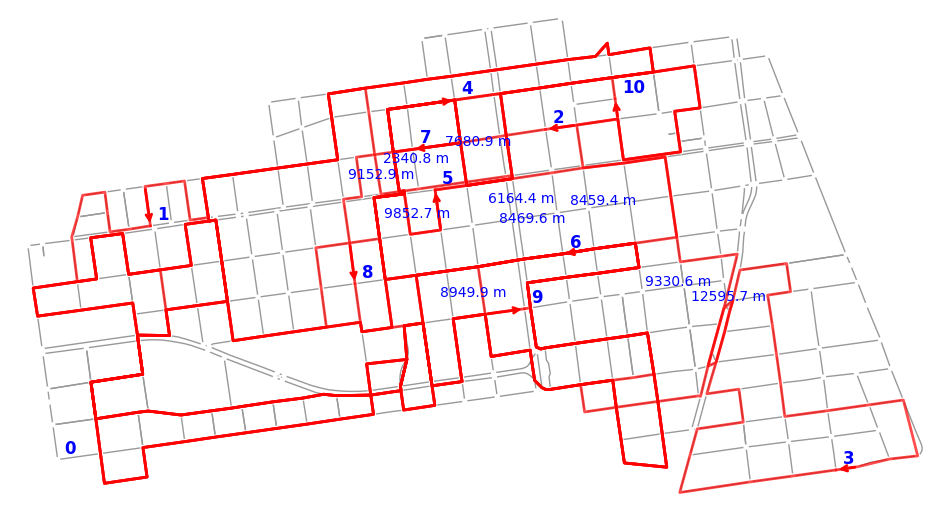

Numero de iglesias a visitar: 10
Longitud total del recorrido: 82997.013 metros
Orden óptimo de nodos: [263112175, 263122144, 263121082, 263120509, 263121077, 257946473, 263358002, 263357752, 263122099, 1273591262, 10313710286]
Velocidad de los feligres: 10 min/Km
Tiempo neto de recorrido: 829.9701300000002 minutos
Tiempo neto de recorrido: 13.832835500000003 horas
tiempo de descanso en cada iglesia: 10 minutos
Numero de iglesias descanso: 9
Tiempo total de recorrido con descanso: 919.9701300000002 minutos
Tiempo total de recorrido con descanso: 15.332835500000003 horas


In [40]:
nodes_base = list(iglesia_nodes)
optimal_order = [posicion_inicial_base] + nodes_base

fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(graph, ax=ax, show=False, close=False)



for i in range(len(optimal_order) - 1):
    path = total_path_dfs[i]
    path_coords = [(graph.nodes[node]['x'], graph.nodes[node]['y']) for node in path]
    x_coords, y_coords = zip(*path_coords)
    ax.plot(x_coords, y_coords, color='r', linewidth=2, alpha=0.7)
    ax.annotate('', xy=(x_coords[-1], y_coords[-1]), xytext=(x_coords[-2], y_coords[-2]),
                arrowprops=dict(arrowstyle='->', color='r', lw=2))
    segment_length = longitud_de_ruta(graph,path)
    mid_x = (x_coords[0] + x_coords[-1]) / 2
    mid_y = (y_coords[0] + y_coords[-1]) / 2
    ax.text(mid_x, mid_y, f'{segment_length:.1f} m', fontsize=10, color='blue')

# Añadir etiquetas a los nodos en el orden de recorrido
for idx, node in enumerate(optimal_order):
    label = str(idx)
    ax.annotate(label, xy=(graph.nodes[node]['x'], graph.nodes[node]['y']), xytext=(5, 5),
                textcoords='offset points', color='blue', fontsize=12, fontweight='bold')



plt.show()

# Obtener la ruta óptima en términos de nodos y resultados
optimal_order = [all_nodes[i] for i in best_path]
print(f"Numero de iglesias a visitar: {len(optimal_order)-1}")
print(f"Longitud total del recorrido: {longitud_total} metros")
print(f"Orden óptimo de nodos: {optimal_order}")
print(f"Velocidad de los feligres: {velocidad_feligres} min/Km")
print(f"Tiempo neto de recorrido: {longitud_total/1000 * velocidad_feligres} minutos")
print(f"Tiempo neto de recorrido: {(longitud_total/1000 * velocidad_feligres)/60} horas")
print(f"tiempo de descanso en cada iglesia: {tiempo_descanso_feligres_x_iglesia} minutos")
print(f"Numero de iglesias descanso: {len(optimal_order)-2}")
print(f"Tiempo total de recorrido con descanso: {longitud_total/1000 * velocidad_feligres + (len(optimal_order)-2) * tiempo_descanso_feligres_x_iglesia} minutos")
print(f"Tiempo total de recorrido con descanso: {(longitud_total/1000 * velocidad_feligres + (len(optimal_order)-2) * tiempo_descanso_feligres_x_iglesia)/60} horas")


### 10. ALGORITMO DE BUSQUEDA EN ESPACIO DE ESTADO: (AVARA - Greedy Best First Search)

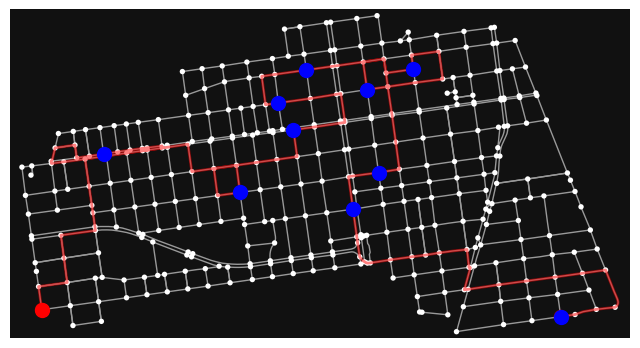

La distancia total de la ruta es: 8704.361000000003 metros
Ruta de vistia a las iglesias: [263112175, 263112176, 263112858, 263112859, 263114100, 263113049, 263114458, 263121089, 263121419, 263121292, 263122088, 263122089, 263122090, 1639104067, 263122091, 1273895001, 263122139, 1639104063, 263122141, 263122142, 263122143, 263122144, 263122145, 263122146, 263360041, 263360133, 263122147, 263122086, 263122087, 263122088, 263122089, 263122090, 1639104067, 263122091, 1273895001, 263122092, 263122093, 263121287, 263121286, 263121285, 263121082, 263121083, 263121286, 263121285, 263121284, 263121283, 263121282, 263122099, 263122100, 263122101, 263122102, 108064624, 108064626, 108171104, 263357751, 263357752, 1658531706, 263358000, 263358001, 263358002, 108171103, 108064627, 257946476, 263118996, 1273833185, 263118997, 257946473, 257946476, 263118996, 1273833185, 1273591262, 263119248, 263119571, 263119570, 4469098639, 263118997, 263118998, 263118999, 263119000, 263119001, 263121077, 10806461

In [43]:
# Función heurística basada en la distancia euclidiana en coordenadas proyectadas
def euclidean_distance_2(node1, node2, graph):
    x1, y1 = graph.nodes[node1]['x'], graph.nodes[node1]['y']
    x2, y2 = graph.nodes[node2]['x'], graph.nodes[node2]['y']
    x1_proj, y1_proj = transformer.transform(x1, y1)
    x2_proj, y2_proj = transformer.transform(x2, y2)
    return ((x1_proj - x2_proj) ** 2 + (y1_proj - y2_proj) ** 2) ** 0.5

# Implementación del algoritmo Greedy Best First Search
def greedy_bfs(graph, start, goal, heuristic):
    queue = [(0, start)]
    visited = set()
    came_from = {start: None}

    while queue:
        _, current = heappop(queue)

        if current == goal:
            break

        if current in visited:
            continue

        visited.add(current)

        for neighbor in graph.neighbors(current):
            if neighbor in visited:
                continue
            priority = heuristic(neighbor, goal, graph)
            heappush(queue, (priority, neighbor))
            came_from[neighbor] = current

    path = []
    while current is not None:
        path.append(current)
        current = came_from[current]
    path.reverse()
    return path

# Encontrar la iglesia más cercana en términos de distancia euclidiana
def find_closest_node(graph, current_node, target_nodes):
    closest_node = min(target_nodes, key=lambda node: euclidean_distance_2(current_node, node, graph))
    #print("***************************************")
    return closest_node

# Recorrer todas las iglesias utilizando el algoritmo Greedy Best First Search
def visit_all_iglesias(graph, start_node, iglesia_nodes):
    visited_path = []
    current_node = start_node
    remaining_iglesia_nodes = iglesia_nodes.copy()

    while remaining_iglesia_nodes:
        closest_node = find_closest_node(graph, current_node, remaining_iglesia_nodes)
        path = greedy_bfs(graph, current_node, closest_node, euclidean_distance_2)
        #print("*********************************************************************************")
        visited_path.extend(path[:-1])  # Agregar el camino sin el último nodo para evitar duplicados
        current_node = closest_node
        remaining_iglesia_nodes.remove(closest_node)

    visited_path.append(current_node)  # Agregar el último nodo visitado
    return visited_path

# Obtener el camino para visitar todas las iglesias
path_to_all_iglesias = visit_all_iglesias(graph, random_node, list(iglesia_nodes))

# Graficar el grafo, los nodos de las iglesias y la ruta
fig, ax = ox.plot_graph(graph, show=False, close=False)

# Graficar los nodos de las iglesias
iglesia_xs = [graph.nodes[node]['x'] for node in iglesia_nodes]
iglesia_ys = [graph.nodes[node]['y'] for node in iglesia_nodes]
ax.scatter(iglesia_xs, iglesia_ys, c='blue', s=100, zorder=5, label='Iglesias')

# Graficar el nodo aleatorio inicial
ax.scatter(graph.nodes[random_node]['x'], graph.nodes[random_node]['y'], c='red', s=100, zorder=5, label='Nodo inicial')

# Graficar la ruta para visitar todas las iglesias
ox.plot_graph_route(graph, path_to_all_iglesias, route_linewidth=2, node_size=0, bgcolor='w', ax=ax, color='green', label='Ruta para visitar todas las iglesias')

# Calcular la distancia total de la ruta
total_distance = 0
for i in range(len(path_to_all_iglesias) - 1):
    u = path_to_all_iglesias[i]
    v = path_to_all_iglesias[i + 1]
    # Sumar la longitud de la arista (u, v)
    edge_data = graph.get_edge_data(u, v)
    if edge_data:  # Verificar si existe la arista (u, v)
        total_distance += edge_data[0]['length']  # Sumamos la longitud de la arista

# Imprimir la distancia total de la ruta
print(f"La distancia total de la ruta es: {total_distance} metros")
print(f"Ruta de vistia a las iglesias: {path_to_all_iglesias}")
plt.show()

# Obtener la ruta óptima en términos de nodos y resultados
path_to_all_iglesias = [all_nodes[i] for i in best_path]
print(f"Numero de iglesias a visitar: {len(path_to_all_iglesias)-1}")
print(f"Longitud total del recorrido: {total_distance} metros")
print(f"Orden óptimo de nodos: {path_to_all_iglesias}")
print(f"Velocidad de los feligres: {velocidad_feligres} min/Km")
print(f"Tiempo neto de recorrido: {total_distance/1000 * velocidad_feligres} minutos")
print(f"Tiempo neto de recorrido: {(total_distance/1000 * velocidad_feligres)/60} horas")
print(f"tiempo de descanso en cada iglesia: {tiempo_descanso_feligres_x_iglesia} minutos")
print(f"Numero de iglesias descanso: {len(path_to_all_iglesias)-2}")
print(f"Tiempo total de recorrido con descanso: {total_distance/1000 * velocidad_feligres + (len(path_to_all_iglesias)-2) * tiempo_descanso_feligres_x_iglesia} minutos")
print(f"Tiempo total de recorrido con descanso: {(total_distance/1000 * velocidad_feligres + (len(path_to_all_iglesias)-2) * tiempo_descanso_feligres_x_iglesia)/60} horas")
